In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangladeshis-flower/Kamini/img_aug_370_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_45_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_407_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_367_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_3_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_origonly_535_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_245_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_319_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_310_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_80_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_372_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_294_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_315_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_94_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_428_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_170_hflip.jpg


In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

**Initializing GPU Usage**

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
IMGSIZE = 90
transform1 = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(0.2),
                                transforms.ToTensor(),
                                transforms.Resize((IMGSIZE,IMGSIZE))
                               ])

**Importing Data**

In [5]:
full_data = torchvision.datasets.ImageFolder(root = '/kaggle/input/bangladeshis-flower', transform = transform1)

In [6]:
classes = full_data.classes
print("Classes:",classes)
num_classes = len(full_data.classes)
print("Number of Classes:",num_classes)

Classes: ['Belly', 'Gondhoraj', 'Kamini', 'Kathgulap', 'Kolaboti', 'Madhobilota', 'Noyontara', 'Rainlily', 'Sondhamaloti', 'Zinnia']
Number of Classes: 10


**Train-Test Data Split**

In [7]:
train_data, test_data = torch.utils.data.random_split(full_data, [16000, 4000])  # In 80% & 20% ratio

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 46, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 46, shuffle = True)

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))
    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

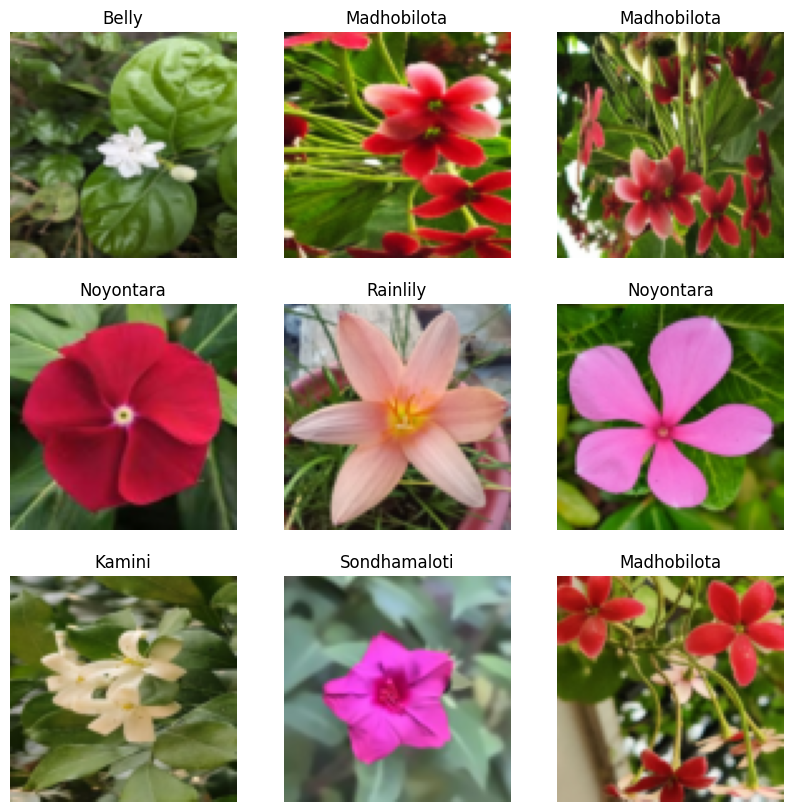

In [10]:
N_IMAGES = 9

images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])

classes = full_data.classes

plot_images(images, labels, classes)

**Modified CNN**

In [11]:
class ModConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ModConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)

        
    def forward(self, x):
        o = self.layer1(x)
        o = self.layer2(o)
        o = self.layer3(o)
        o = self.layer4(o)
        o = self.layer5(o)
        o = self.layer6(o)
        o = o.reshape(o.size(0), -1)
        o = self.fc1(o)
        o = F.dropout(o, training=self.training)
        o = self.fc2(o)
        o = F.dropout(o, training=self.training)
        o = self.fc3(o)
        return F.log_softmax(o,dim=1)

model = ModConvNet(num_classes).to(device)

**Criteria and Adam Optimizer**

In [12]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(model.parameters(),lr=1e-5,weight_decay=1e-5)

In [13]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [14]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        model.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()

    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 0.84;   Train Accuracy : 56.99%;   Test Loss : 0.75;   Test Accuracy : 76.20%
Epoch 2 =>  Train Loss : 0.52;   Train Accuracy : 75.34%;   Test Loss : 0.56;   Test Accuracy : 82.65%
Epoch 3 =>  Train Loss : 0.35;   Train Accuracy : 81.67%;   Test Loss : 0.50;   Test Accuracy : 85.50%
Epoch 4 =>  Train Loss : 0.42;   Train Accuracy : 86.44%;   Test Loss : 0.15;   Test Accuracy : 89.78%
Epoch 5 =>  Train Loss : 0.25;   Train Accuracy : 90.21%;   Test Loss : 0.21;   Test Accuracy : 91.40%
Epoch 6 =>  Train Loss : 0.38;   Train Accuracy : 92.67%;   Test Loss : 0.19;   Test Accuracy : 91.47%
Epoch 7 =>  Train Loss : 0.10;   Train Accuracy : 94.27%;   Test Loss : 0.17;   Test Accuracy : 93.80%
Epoch 8 =>  Train Loss : 0.14;   Train Accuracy : 95.73%;   Test Loss : 0.40;   Test Accuracy : 94.92%
Epoch 9 =>  Train Loss : 0.13;   Train Accuracy : 96.64%;   Test Loss : 0.14;   Test Accuracy : 95.42%
Epoch 10 =>  Train Loss : 0.11;   Train Accuracy : 97.44%;   Test Loss : 

In [37]:
torch.save(model.state_dict(), 'ModCNNModel.ckpt')

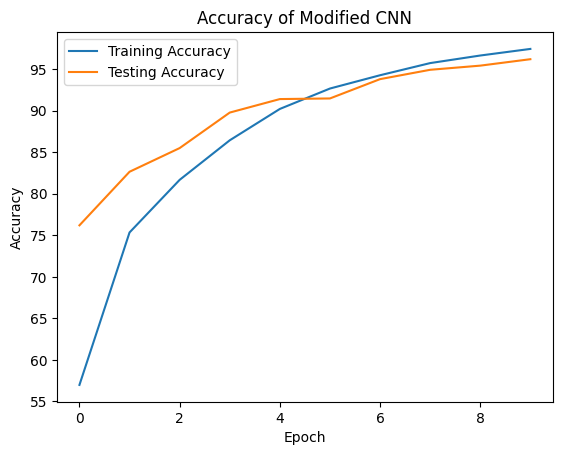

In [18]:
plt.plot(range(len(TrainAcc)), TrainAcc)
plt.plot(range(len(TestAcc)), TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of Modified CNN")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()


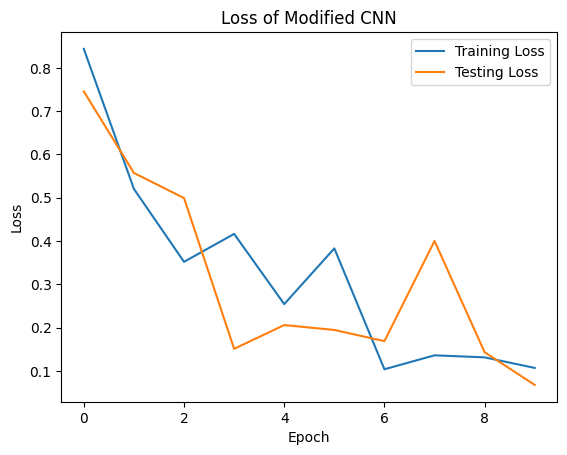

In [26]:
TrainLoss = [loss.cpu().item() for loss in TrainLoss]
TestLoss = [loss.cpu().item() for loss in TestLoss]

plt.plot(range(10),TrainLoss)
plt.plot(range(10),TestLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of Modified CNN")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

**Confusion Matrix**

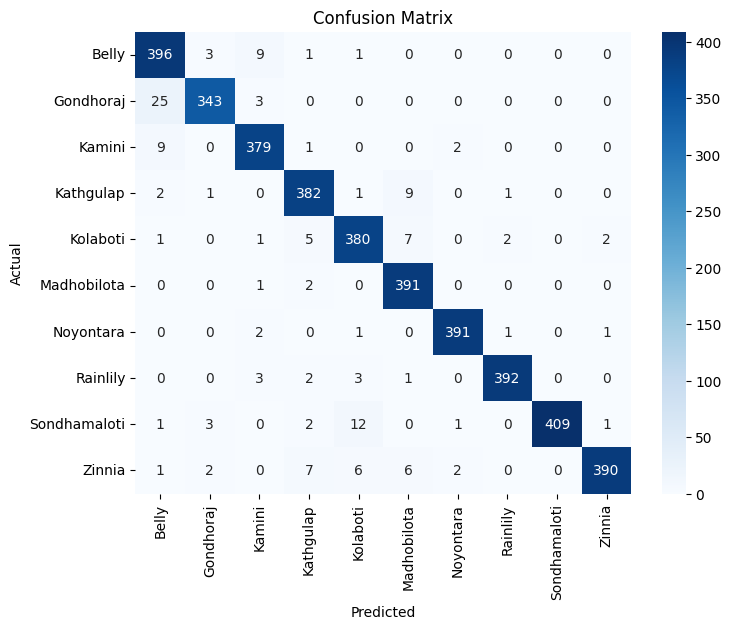

In [40]:
# Define class names
class_names = ['Belly', 'Gondhoraj', 'Kamini', 'Kathgulap', 'Kolaboti',  
               'Madhobilota', 'Noyontara', 'Rainlily', 'Sondhamaloti', 'Zinnia']

# Store all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.data.max(dim=1)[1]  # Get predicted class indices

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Classification Report**

In [41]:
# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds))

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       410
           1       0.97      0.92      0.95       371
           2       0.95      0.97      0.96       391
           3       0.95      0.96      0.96       396
           4       0.94      0.95      0.95       398
           5       0.94      0.99      0.97       394
           6       0.99      0.99      0.99       396
           7       0.99      0.98      0.98       401
           8       1.00      0.95      0.98       429
           9       0.99      0.94      0.97       414

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



**F1 Score**

In [42]:
# F1 Score (macro average for multiple classes)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (Macro Avg): {f1:.4f}")

F1 Score (Macro Avg): 0.9632


**GoogleNet**

In [27]:
googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 174MB/s] 


In [28]:
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [29]:
q = googlenet.fc.in_features
googlenet.fc = nn.Linear(q, num_classes)

googlenet = googlenet.cuda()

**GoogleNet with Adam Optimizer**

In [30]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(googlenet.parameters(),lr=1e-5,weight_decay=1e-5)

In [31]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [32]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        googlenet.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = googlenet(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()

        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        googlenet.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = googlenet(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()

    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 1.48;   Train Accuracy : 37.94%;   Test Loss : 1.51;   Test Accuracy : 68.15%
Epoch 2 =>  Train Loss : 0.96;   Train Accuracy : 73.26%;   Test Loss : 0.91;   Test Accuracy : 81.18%
Epoch 3 =>  Train Loss : 0.60;   Train Accuracy : 83.34%;   Test Loss : 0.42;   Test Accuracy : 88.72%
Epoch 4 =>  Train Loss : 0.41;   Train Accuracy : 88.70%;   Test Loss : 0.41;   Test Accuracy : 92.47%
Epoch 5 =>  Train Loss : 0.24;   Train Accuracy : 92.22%;   Test Loss : 0.20;   Test Accuracy : 95.07%
Epoch 6 =>  Train Loss : 0.13;   Train Accuracy : 94.31%;   Test Loss : 0.13;   Test Accuracy : 96.32%
Epoch 7 =>  Train Loss : 0.18;   Train Accuracy : 95.96%;   Test Loss : 0.06;   Test Accuracy : 97.20%
Epoch 8 =>  Train Loss : 0.21;   Train Accuracy : 96.61%;   Test Loss : 0.17;   Test Accuracy : 97.68%
Epoch 9 =>  Train Loss : 0.15;   Train Accuracy : 97.43%;   Test Loss : 0.10;   Test Accuracy : 98.03%
Epoch 10 =>  Train Loss : 0.07;   Train Accuracy : 98.11%;   Test Loss : 

In [36]:
torch.save(googlenet.state_dict(), 'GoogleNetModel.ckpt')

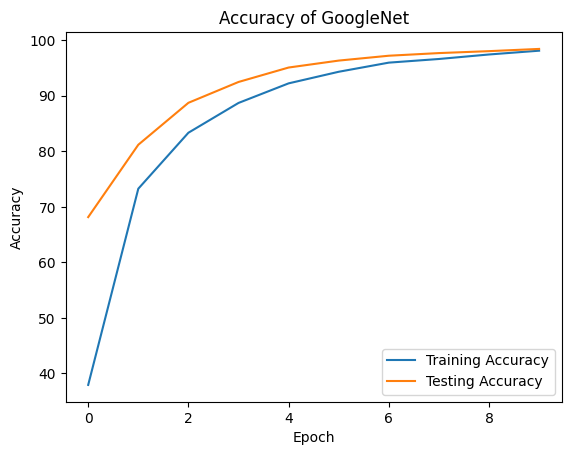

In [33]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of GoogleNet")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

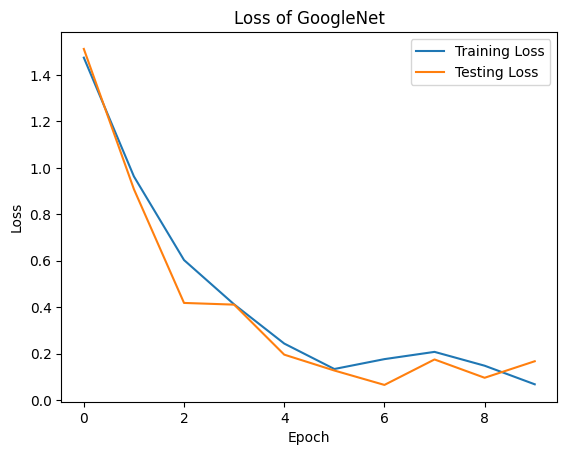

In [35]:
TrainLoss = [loss.cpu().item() for loss in TrainLoss]
TestLoss = [loss.cpu().item() for loss in TestLoss]

plt.plot(range(10),TrainLoss)
plt.plot(range(10),TestLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of GoogleNet")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

**Confusion Matrix**

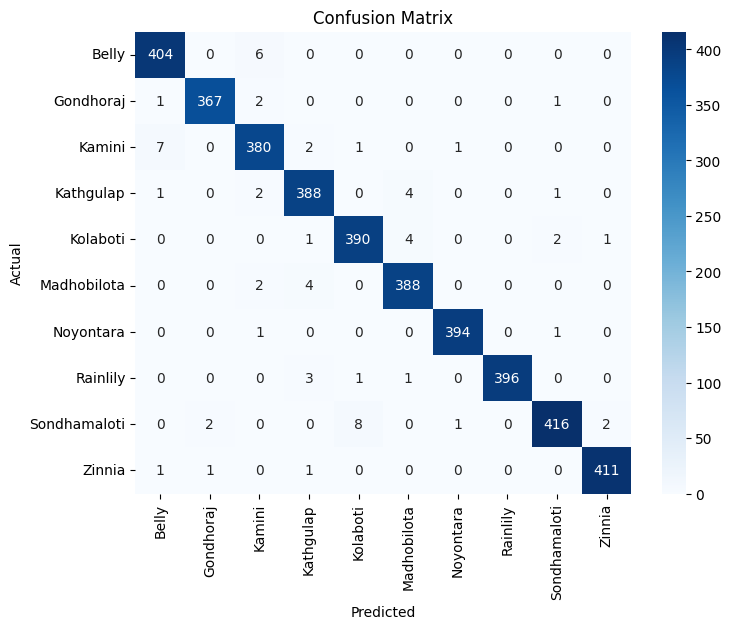

In [44]:
googlenet.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = googlenet(images)
        preds = outputs.data.max(dim=1)[1]
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Define class names
class_names = ['Belly', 'Gondhoraj', 'Kamini', 'Kathgulap', 'Kolaboti',  
               'Madhobilota', 'Noyontara', 'Rainlily', 'Sondhamaloti', 'Zinnia']

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Classification Report**

In [45]:
# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

       Belly       0.98      0.99      0.98       410
   Gondhoraj       0.99      0.99      0.99       371
      Kamini       0.97      0.97      0.97       391
   Kathgulap       0.97      0.98      0.98       396
    Kolaboti       0.97      0.98      0.98       398
 Madhobilota       0.98      0.98      0.98       394
   Noyontara       0.99      0.99      0.99       396
    Rainlily       1.00      0.99      0.99       401
Sondhamaloti       0.99      0.97      0.98       429
      Zinnia       0.99      0.99      0.99       414

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



**F1 Score**

In [46]:

# F1 Score (macro average)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Macro-averaged F1 Score: {f1:.4f}")

Macro-averaged F1 Score: 0.9835


**GoogleNet with SGD Optimizer**

In [47]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.SGD(googlenet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


In [48]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [49]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []

for epoch in range(num_epochs):
    googlenet.train()
    train_correct = 0
    train_loss_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimz.zero_grad()
        outputs = googlenet(images)
        loss = criter(outputs, labels)
        loss.backward()
        optimz.step()

        train_loss_total += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        train_correct += preds.eq(labels).sum().item()

    avg_train_loss = train_loss_total / len(train_loader.dataset)
    avg_train_acc = 100.0 * train_correct / len(train_loader.dataset)

    googlenet.eval()
    test_correct = 0
    test_loss_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criter(outputs, labels)
            
            test_loss_total += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            test_correct += preds.eq(labels).sum().item()

    avg_test_loss = test_loss_total / len(test_loader.dataset)
    avg_test_acc = 100.0 * test_correct / len(test_loader.dataset)

    print(f"Epoch {epoch+1} => Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.2f}%")

    TrainLoss.append(avg_train_loss)
    TrainAcc.append(avg_train_acc)
    TestLoss.append(avg_test_loss)
    TestAcc.append(avg_test_acc)


Epoch 1 => Train Loss: 0.1300, Train Acc: 95.86%, Test Loss: 0.4464, Test Acc: 89.30%
Epoch 2 => Train Loss: 0.0727, Train Acc: 97.71%, Test Loss: 0.0431, Test Acc: 98.62%
Epoch 3 => Train Loss: 0.0315, Train Acc: 98.98%, Test Loss: 0.0698, Test Acc: 98.22%
Epoch 4 => Train Loss: 0.0246, Train Acc: 99.19%, Test Loss: 0.0286, Test Acc: 99.20%
Epoch 5 => Train Loss: 0.0166, Train Acc: 99.49%, Test Loss: 0.0225, Test Acc: 99.30%
Epoch 6 => Train Loss: 0.0124, Train Acc: 99.61%, Test Loss: 0.0378, Test Acc: 98.90%
Epoch 7 => Train Loss: 0.0113, Train Acc: 99.66%, Test Loss: 0.0169, Test Acc: 99.45%
Epoch 8 => Train Loss: 0.0094, Train Acc: 99.69%, Test Loss: 0.0243, Test Acc: 99.28%
Epoch 9 => Train Loss: 0.0112, Train Acc: 99.66%, Test Loss: 0.0187, Test Acc: 99.62%
Epoch 10 => Train Loss: 0.0121, Train Acc: 99.60%, Test Loss: 0.0245, Test Acc: 99.45%


In [50]:
torch.save(googlenet.state_dict(), 'GoogleNetModel(SGD).ckpt')

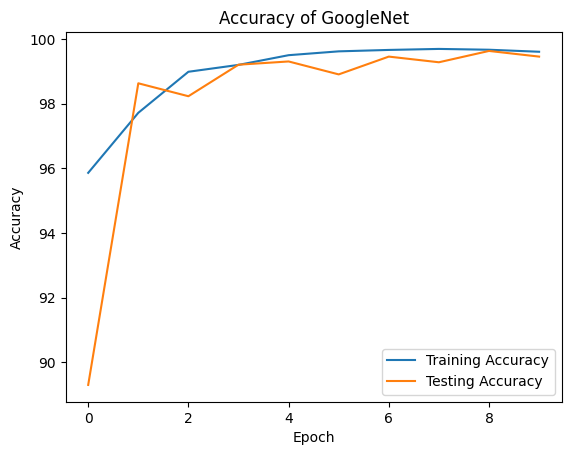

In [51]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of GoogleNet")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

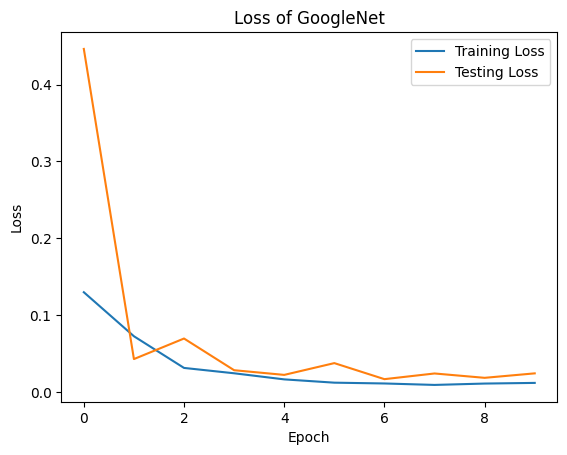

In [53]:
plt.plot(range(10),TrainLoss)
plt.plot(range(10),TestLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of GoogleNet")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

**Confusion Matrix**

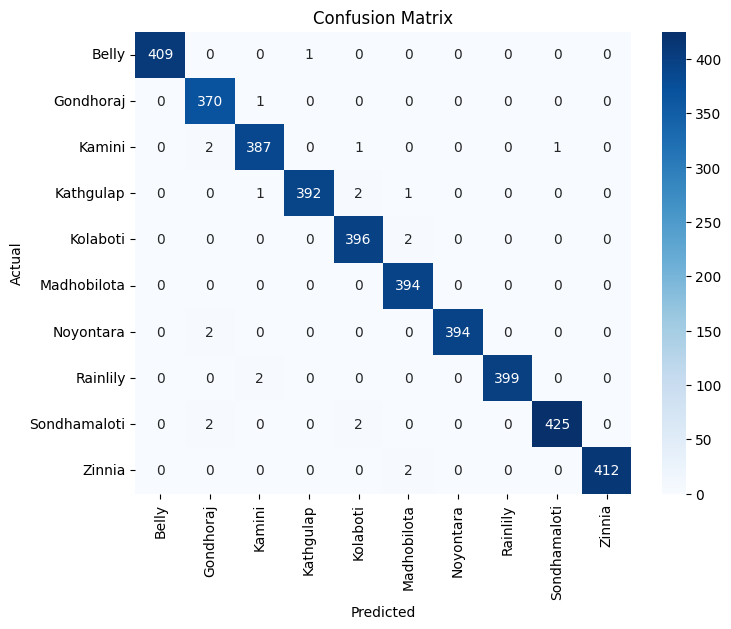

In [54]:
googlenet.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = googlenet(images)
        preds = outputs.data.max(dim=1)[1]
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Define class names
class_names = ['Belly', 'Gondhoraj', 'Kamini', 'Kathgulap', 'Kolaboti',  
               'Madhobilota', 'Noyontara', 'Rainlily', 'Sondhamaloti', 'Zinnia']

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Classification Report**

In [55]:
# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

       Belly       1.00      1.00      1.00       410
   Gondhoraj       0.98      1.00      0.99       371
      Kamini       0.99      0.99      0.99       391
   Kathgulap       1.00      0.99      0.99       396
    Kolaboti       0.99      0.99      0.99       398
 Madhobilota       0.99      1.00      0.99       394
   Noyontara       1.00      0.99      1.00       396
    Rainlily       1.00      1.00      1.00       401
Sondhamaloti       1.00      0.99      0.99       429
      Zinnia       1.00      1.00      1.00       414

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



**F1 Score**

In [56]:

# F1 Score (macro average)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Macro-averaged F1 Score: {f1:.4f}")

Macro-averaged F1 Score: 0.9944
